In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from argparse import Namespace
import matplotlib.pyplot as plt
import av2.rendering.vector as vector_plotting_utils
from shapely.geometry import Polygon

from MapGraph import MapGraph
from ActorGraph import ActorGraph

from av2.map.map_api import ArgoverseStaticMap
from av2.datasets.motion_forecasting import scenario_serialization

from av2.datasets.motion_forecasting.viz.scenario_visualization import (
    visualize_scenario
)
from av2.map.map_api import ArgoverseStaticMap
import os 
os.getcwd()


from graph_creator.create_graph import get_scenario_data, plot_scene_at_timestep

In [2]:
from pathlib import Path
repo_root = Path("/Users/marius/code/graph_coverage")
dataroot = repo_root / "argoverse_data" / "train"
print(repo_root)




/Users/marius/code/graph_coverage


In [3]:
scenario_folders = [f for f in dataroot.iterdir() if f.is_dir()]

# Print number of scenarios found
print(f"Found {len(scenario_folders)} scenarios")

Found 199908 scenarios


000ace8b-a3d2-4228-bd87-91b66a9c5127

following_lead: 2 total edges

leading_vehicle: 0 total edges

neighbor_vehicle: 0 total edges

opposite_vehicle: 4 total edges


/Users/marius/code/graph_coverage/graph_creator/MapGraph.py:292: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  with open(save_path, "wb") as file:


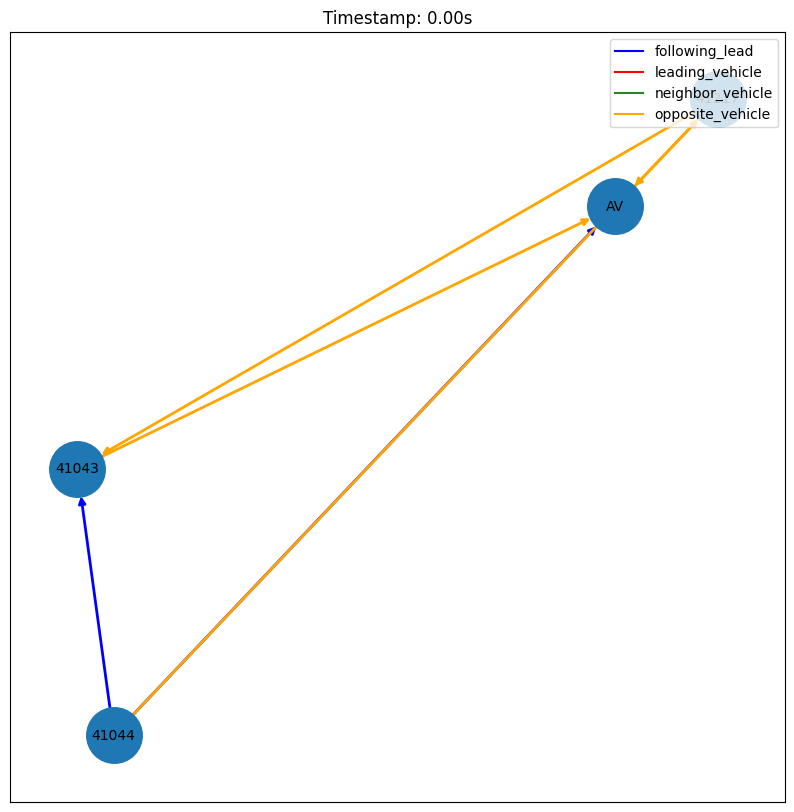

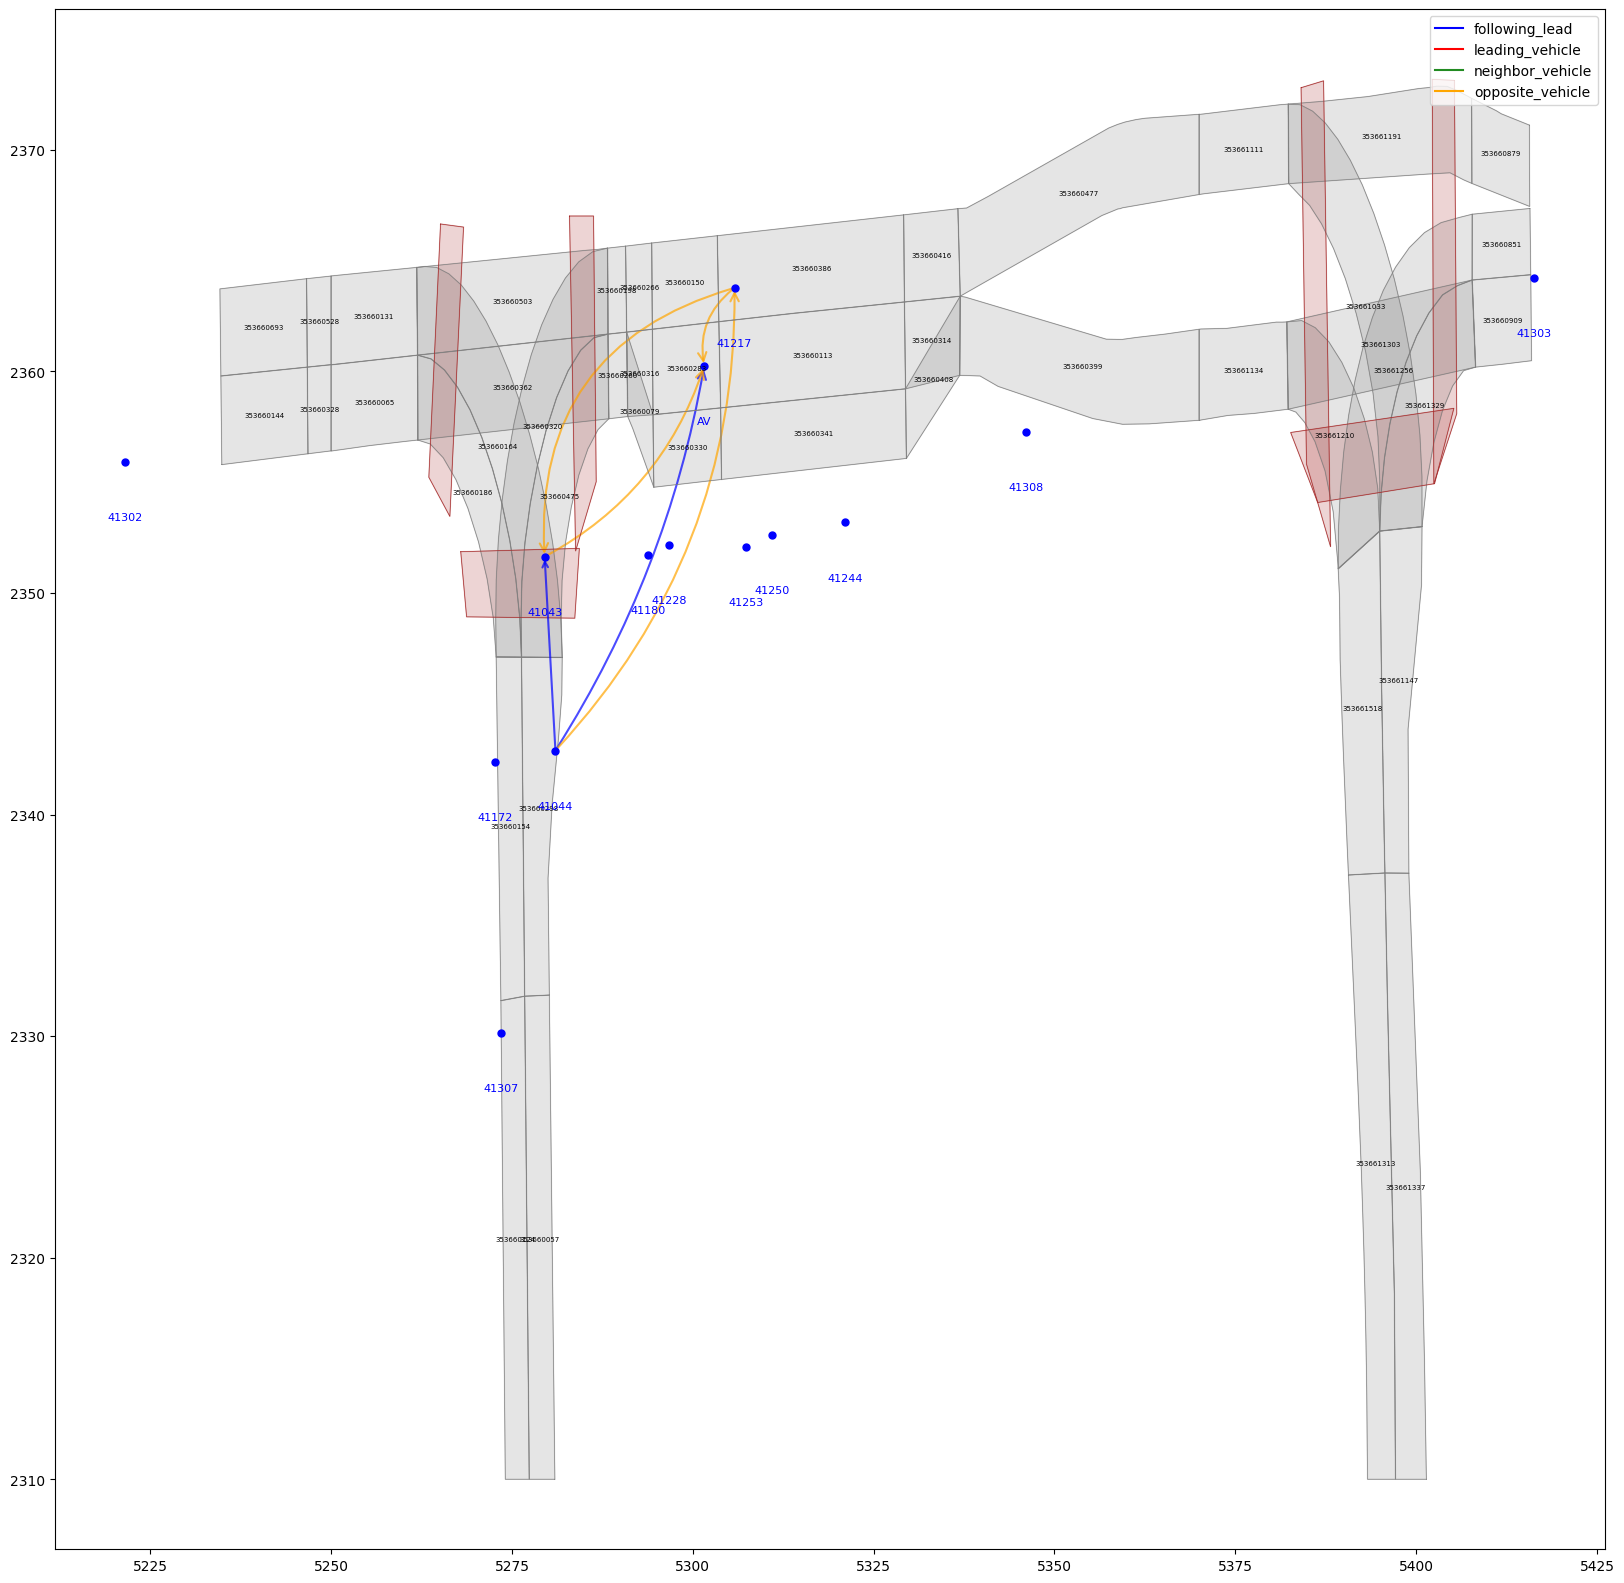

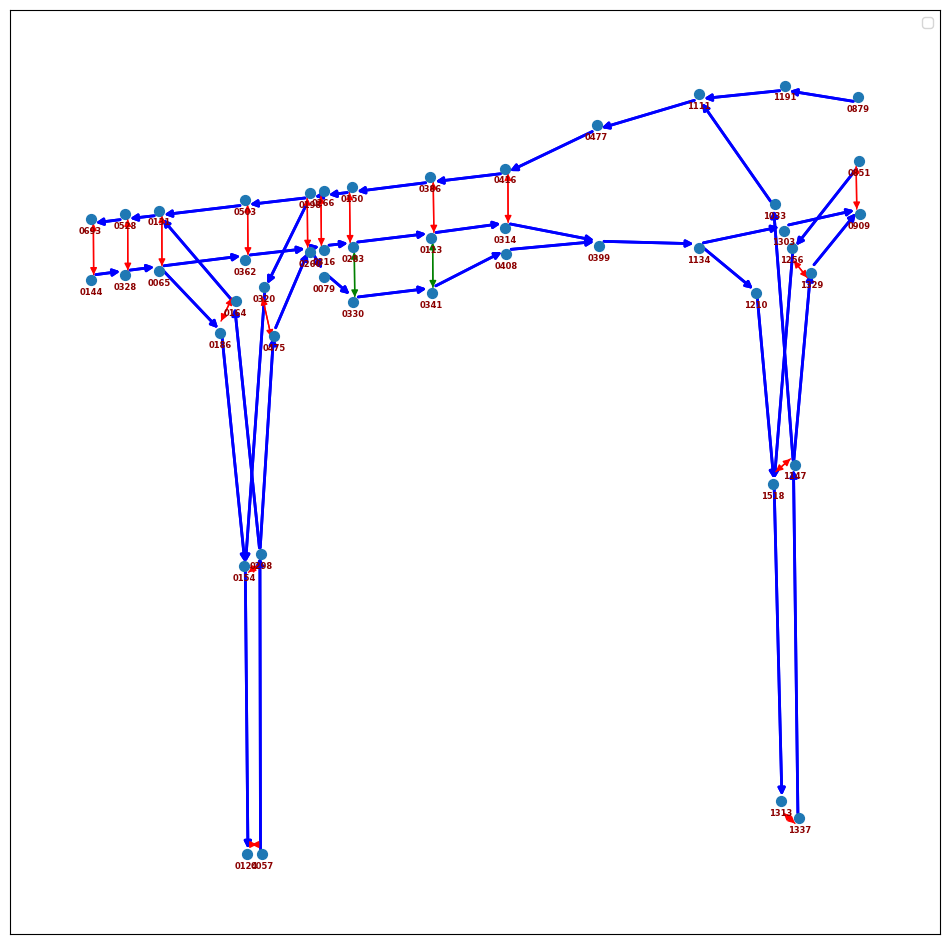

In [25]:
# Only process first 5 scenarios
actor_graphs = []

for i, scenario in enumerate(scenario_folders):
    if i >= 1:
        break
#if True: 
    #log_id = 'd25d1aaa-8bb2-4c6b-98a5-fa5aa2ddd2eb'
    log_id = scenario.name
    print(log_id)
    scenario, map = get_scenario_data(dataroot, log_id)
    G_map = MapGraph.create_from_argoverse_map(map)
    actor_graph = ActorGraph.from_argoverse_scenario(
                                    scenario, 
                                    G_map, 
                                    delta_timestep_s=100.0,
                                    max_distance_lead_veh_m=100,
                                    max_distance_opposite_veh_m=200,
                                    max_distance_neighbor_forward_m=100,
                                    max_distance_neighbor_backward_m=100,
                                    max_number_lead_vehicle=1,
                                    max_number_neighbor=0,
                                    max_number_opposite=0,
                                    max_node_distance=100000,
    )
    actor_graphs.append(actor_graph)
    actor_graph.visualize_actor_graph(t_idx=0.0, comp_idx=0,  save_path=(repo_root / "plots" / f"{log_id}_actor_graph.png"))
#visualize_scenario(scenario, map, save_path=(repo_root / "plots" / f"{log_id}_video_.mp4") )
    timestamp=0.0
    plot_scene_at_timestep(scenario, map, timestamp, save_path=(repo_root / "plots" / f"{log_id}_scene_at_{timestamp}.png"), lane_label=True, actor_graph=actor_graph)
    G_map.visualize_graph(save_path=(repo_root / "plots" / f"{log_id}_map_graph.png"))

In [9]:
import pickle
# Save actor graphs and map data to pickle files
output_dir = repo_root / "data"
output_dir.mkdir(exist_ok=True)

# Save actor graphs
actor_graphs_file = output_dir / "actor_graph_argoverse.pkl"
with open(actor_graphs_file, "wb") as f:
    pickle.dump(actor_graphs, f)

# Save map data for each scenario
map_file = output_dir / f"map_argoverse.pkl"
with open(map_file, "wb") as f:
    pickle.dump(G_map, f)



In [22]:
from graph_creator.SubgraphExtractor import SubgraphExtractor
import os

# Example usage of the SubgraphExtractor
def analyze_actor_graphs(actor_graphs, strategy='frequency', output_dir=None):
    """
    Analyze actor graphs to find common subgraphs using the specified strategy.
    
    Args:
        actor_graphs: List of ActorGraph objects
        strategy: Strategy for selecting subgraphs
        output_dir: Directory to save visualizations
    
    Returns:
        SubgraphExtractor instance
    """
    
    # Initialize extractor with specified strategy
    extractor = SubgraphExtractor(
        min_subgraph_size=3,
        max_subgraph_size=5, 
        # Custom matchers can be defined here if needed
    )
    
    # Extract subgraphs
    subgraph_library = extractor.extract_subgraphs(actor_graphs[:10])
    
    # Print properties
    extractor.print_subgraph_properties()
    
    # Visualize subgraphs
    if output_dir is not None:
        strategy_dir = os.path.join(output_dir, f"strategy_{strategy}")
        extractor.visualize_subgraphs(output_dir=strategy_dir)
    else:
        extractor.visualize_subgraphs()
    
    return extractor

# Create visualization output directory
output_dir = repo_root /  "plots" / "subgraph_analysis"
os.makedirs(output_dir, exist_ok=True)

# Analyze with different strategies
strategies = ['frequency', 'density', 'coverage', 'complexity', 'size']
extractors = {}

for strategy in strategies:
    extractors[strategy] = analyze_actor_graphs(actor_graphs, strategy, output_dir)

# Example of how to access the subgraphs for a specific actor graph and timestamp
print("\nExample of subgraph decomposition:")
print("=================================")
example_graph_idx = 0  # First graph in the list
example_timestamp = list(actor_graphs[example_graph_idx].actor_graphs.keys())[0]
print(f"Graph {example_graph_idx}, Timestamp {example_timestamp}:")

for sg_info in actor_graphs[example_graph_idx].actor_subgraphs[example_timestamp]:
    sg_id = sg_info['subgraph_id']
    nodes = sg_info['nodes']
    print(f"  Subgraph ID: {sg_id}, Nodes: {nodes}")
    # Additional information can be accessed from sg_info['node_mapping']

Processing actor graph <ActorGraph.ActorGraph object at 0x1687e8940>
Processing time 0.0 of 2
Processing graph with n_nodes 4 and n_edges 8
Saved graph visualization to: /Users/marius/code/graph_coverage/plots/subgraph_analysis/graph_actor_<ActorGraph.ActorGraph object at 0x1687e8940>_time_0.0.png
Processing time 10.9 of 2
Processing graph with n_nodes 2 and n_edges 2
Saved graph visualization to: /Users/marius/code/graph_coverage/plots/subgraph_analysis/graph_actor_<ActorGraph.ActorGraph object at 0x1687e8940>_time_10.9.png
Processing actor graph <ActorGraph.ActorGraph object at 0x1687851b0>
Processing time 0.0 of 2
Processing graph with n_nodes 38 and n_edges 870
Saved graph visualization to: /Users/marius/code/graph_coverage/plots/subgraph_analysis/graph_actor_<ActorGraph.ActorGraph object at 0x1687851b0>_time_0.0.png


KeyboardInterrupt: 